# CMSC 636, HW3: ConvNet on MNIST dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from types import SimpleNamespace
%matplotlib inline

## Load MNIST

In [2]:
# load mnist dataset with labels encoded as one-hot vectors
class Dataset():
    def __init__(self, data):
        self.data = data
        self.index = 0
        self.epochs = 0

    def shuffle(self):
        perm = np.arange(self.data[0].shape[0])
        np.random.shuffle(perm)
        self.data = tuple(datai[perm] for datai in self.data)
    
    def next_batch(self, batch_size):
        start = self.index
        end = self.index + batch_size
        if end > self.data[0].shape[0]:
            self.epochs += 1
            self.shuffle()
            self.index, start = 0, 0
            end = batch_size
        self.index = end
        return tuple(datai[start:end, ...] for datai in self.data)
            
def load_mnist():
    def preprocess(data, labels, num_classes):
        # flatten images
        data = data.astype(np.float32)/255.0
        data = np.reshape(data, [data.shape[0], -1])
        # one hot encoding
        num_labels = labels.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels.ravel()] = 1
        return data, labels_one_hot
    train, test = tf.keras.datasets.mnist.load_data()
    train = preprocess(train[0], train[1], 10)
    test = preprocess(test[0], test[1], 10)
    return SimpleNamespace(
        train=Dataset(train), 
        test=Dataset(test))
mnist = load_mnist()

## Model definition

In [3]:
sess = tf.InteractiveSession()

In [4]:
input_size= [28, 28]

n_outputs= 10
n_input_maps= 32 #''' HINT: The images are gray scale '''

n_maps = 64
filter_size = [5, 5]
pool_size =   [2, 2]
n_hidden = 256

batch_size= 100 # play with different values for batch size

In [5]:
# Define the ConvNet
# 1. Define the weights for the network

# weights for first convolutional layer #
''' HINT: The variables instantiation should look something similar to: '''
# w1 = tf.Variable(
#     tf.truncated_normal(
#         shape=[filter_size_dim1, filter_size_dim2, #input_maps, #output_maps], 
#         stddev=0.1), 
#     name= 'w1')
# b1 = tf.Variable(
#     tf.truncated_normal(
#         shape=[#output_maps], 
#         stddev=0.1), 
#     name= 'b1')

w1 = tf.Variable(
        tf.truncated_normal(
        shape=[filter_size[0], filter_size[1], 1, n_input_maps], 
        stddev=0.1), 
    name= 'w1')
b1 = tf.Variable(
        tf.truncated_normal(
        shape=[n_input_maps], 
        stddev=0.1), 
    name= 'b1')

# # weights for second convolutional layer
w2 = tf.Variable(
        tf.truncated_normal(
        shape=[filter_size[0], filter_size[1], n_input_maps, n_maps], 
        stddev=0.1), 
    name= 'w2')
b2 = tf.Variable(
        tf.truncated_normal(
        shape=[n_maps], 
        stddev=0.1), 
    name= 'b2')

# # weights for fully connected layer
w3 = tf.Variable(
        tf.truncated_normal(
        shape=[4 * 4 * n_maps, n_hidden], 
        stddev=0.1), 
    name= 'w3')
b3 = tf.Variable(
        tf.truncated_normal(
        shape=[n_hidden], 
        stddev=0.1), 
    name= 'b3')

# # weights for final linear layer
w4 = tf.Variable(
        tf.truncated_normal(
        shape=[n_hidden, n_outputs], 
        stddev=0.1), 
    name= 'w4')
b4 = tf.Variable(
        tf.truncated_normal(
        shape=[n_outputs], 
        stddev=0.1), 
    name= 'b4')

# Define place holders for feeding training and testing data
inputs = tf.placeholder(tf.float32, shape=[None, 28, 28, 1]) 
labels = tf.placeholder(tf.float32, shape=[None, n_outputs])

# Construct computation graph
conv1 = tf.nn.conv2d(inputs, w1, strides=[1, 1, 1, 1], padding='VALID')
h1 = tf.nn.relu(conv1 + b1)
pool1 = tf.nn.max_pool(h1, ksize=  [1, pool_size[0], pool_size[1], 1],
                           strides=[1, pool_size[0], pool_size[1], 1], 
                           padding='VALID')

conv2 = tf.nn.conv2d(pool1, w2, strides=[1, 1, 1, 1], padding='VALID')
h2 = tf.nn.relu(conv2 + b2)
pool2 = tf.nn.max_pool(h2, ksize=  [1, pool_size[0], pool_size[1], 1],
                           strides=[1, pool_size[0], pool_size[1], 1], 
                           padding='VALID')
# # Reshape maps 
# ''' HINT: where does 4*4*64 comes from? use the architecture given in the assignment to figure this out !!! '''
conv_out = tf.reshape(pool2, [-1, 4*4*64]) 
h3 = tf.nn.relu(tf.matmul(conv_out, w3) + b3)

logits  = tf.matmul(h3, w4) + b4
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, 
    labels=labels)) 

# Optimizer.
optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss) #0.001
  
# Predictions for the training, validation, and test data.
yp = tf.nn.softmax(logits)

Instructions for updating:
Colocations handled automatically by placer.


## Training

In [6]:
def accuracy(predictions, labels):
    if n_outputs == 1:
        return (100.0 * np.sum(np.greater(predictions, 0.5) == np.greater(labels, 0.5))/ predictions.shape[0])
    else:
        return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

In [45]:
num_steps = 5000
# num_steps = 1 # TODO: remove
summary_freq= 200

tf.global_variables_initializer().run()
print('Initialized')

# lists for plotting
l_epoch = []
l_train_accuracy = []
l_test_accuracy = []

mean_loss= 0
train_accuracy= 0
for step in range(num_steps):
    # Get next batch of 100 images
    batch_X, batch_y= mnist.train.next_batch(batch_size)
    # The images returned by the function are formated in a matrix,
    # where each row represents an image. Hence, we must reshape such
    # matrix to convert the vector-representation of the images to 
    # standard 28 by 28 grey images.
    batch_X = np.reshape(batch_X, [-1,28,28,1]) 
    # Construct Feed dictionary that consist of the input data 
    # that is going to be feed into the computation graph
    feed_dict = {inputs : batch_X, labels : batch_y}
    # Call the optimizer to perform one step of the training
    _, l, train_pred = sess.run([optimizer, loss, yp],feed_dict=feed_dict)
    
    train_accuracy += accuracy(train_pred, batch_y)
    mean_loss += l    
    
    if step%summary_freq == 0:
        # obtain train accuracy
        train_accuracy= train_accuracy/summary_freq
        
        # Evaluate the accuracy on a mini-batch of ~100 images
        # extracted from the testing dataset
        test_accuracy = 0
        for i in range(100):
            batch_X_test, batch_y_test= mnist.test.next_batch(batch_size) 
            batch_X_test = np.reshape(batch_X_test, [-1,28,28,1]) 
            pred = yp.eval(feed_dict={inputs: batch_X_test})
            test_accuracy += accuracy(pred, batch_y_test)
        test_accuracy = test_accuracy / 100
        
        l_epoch.append(step)
        l_train_accuracy.append(train_accuracy)
        l_test_accuracy.append(test_accuracy)
        
        # ------------------------------- #
        print(step, ', train:',train_accuracy,' | test:', test_accuracy, ' | loss:', mean_loss/summary_freq)
        mean_loss= 0
        train_accuracy= 0

Initialized
0 , train: 0.06  | test: 17.01  | loss: 0.012836241722106933
200 , train: 91.085  | test: 96.47  | loss: 0.289343212749809
400 , train: 97.33  | test: 97.35  | loss: 0.08360564906150103
600 , train: 98.035  | test: 98.25  | loss: 0.06573127842508257
800 , train: 98.4  | test: 98.75  | loss: 0.052325262643862516
1000 , train: 98.755  | test: 98.67  | loss: 0.041719958810135724
1200 , train: 98.745  | test: 98.68  | loss: 0.037894258153392
1400 , train: 99.025  | test: 98.67  | loss: 0.03019301096748677
1600 , train: 99.165  | test: 98.88  | loss: 0.02652749541623052
1800 , train: 99.055  | test: 98.78  | loss: 0.02893758003541734
2000 , train: 99.2  | test: 98.99  | loss: 0.023839355314848945
2200 , train: 99.595  | test: 99.11  | loss: 0.013746323643317737
2400 , train: 99.455  | test: 99.05  | loss: 0.018000142862074426
2600 , train: 99.295  | test: 99.08  | loss: 0.021825761904910906
2800 , train: 99.44  | test: 98.91  | loss: 0.015641579651965002
3000 , train: 99.5  | te

## Test the trained model on the testing dataset

Number: 8
Prediction by the model: 8


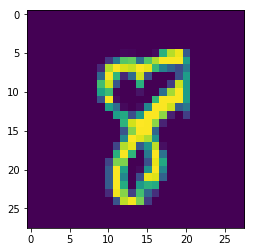

In [46]:
# Acquire one sample from the mnist dataset
test_sample_x, test_sample_y= mnist.test.next_batch(1) 
test_sample_x = np.reshape(test_sample_x, [-1,28,28,1])

# Evaluate the training model on test_sample_x
# and compare it with the actual label test_sample_y
pred = yp.eval(feed_dict={inputs:test_sample_x})
print('Number:', np.argmax(test_sample_y))
print('Prediction by the model:', np.argmax(pred))
# ------------------------------- #

# Plot
plt.imshow(np.squeeze(test_sample_x))

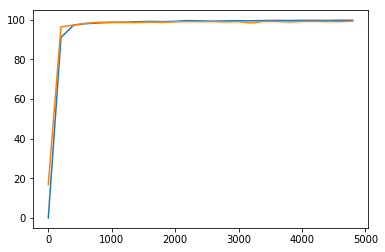

In [47]:
plt.plot(l_epoch, l_train_accuracy, label="Training Accuracy")
plt.plot(l_epoch, l_test_accuracy, label="Testing Accuracy")